<a href="https://colab.research.google.com/github/JerryEnes/Multimodal-Biometrics/blob/main/Untitled8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

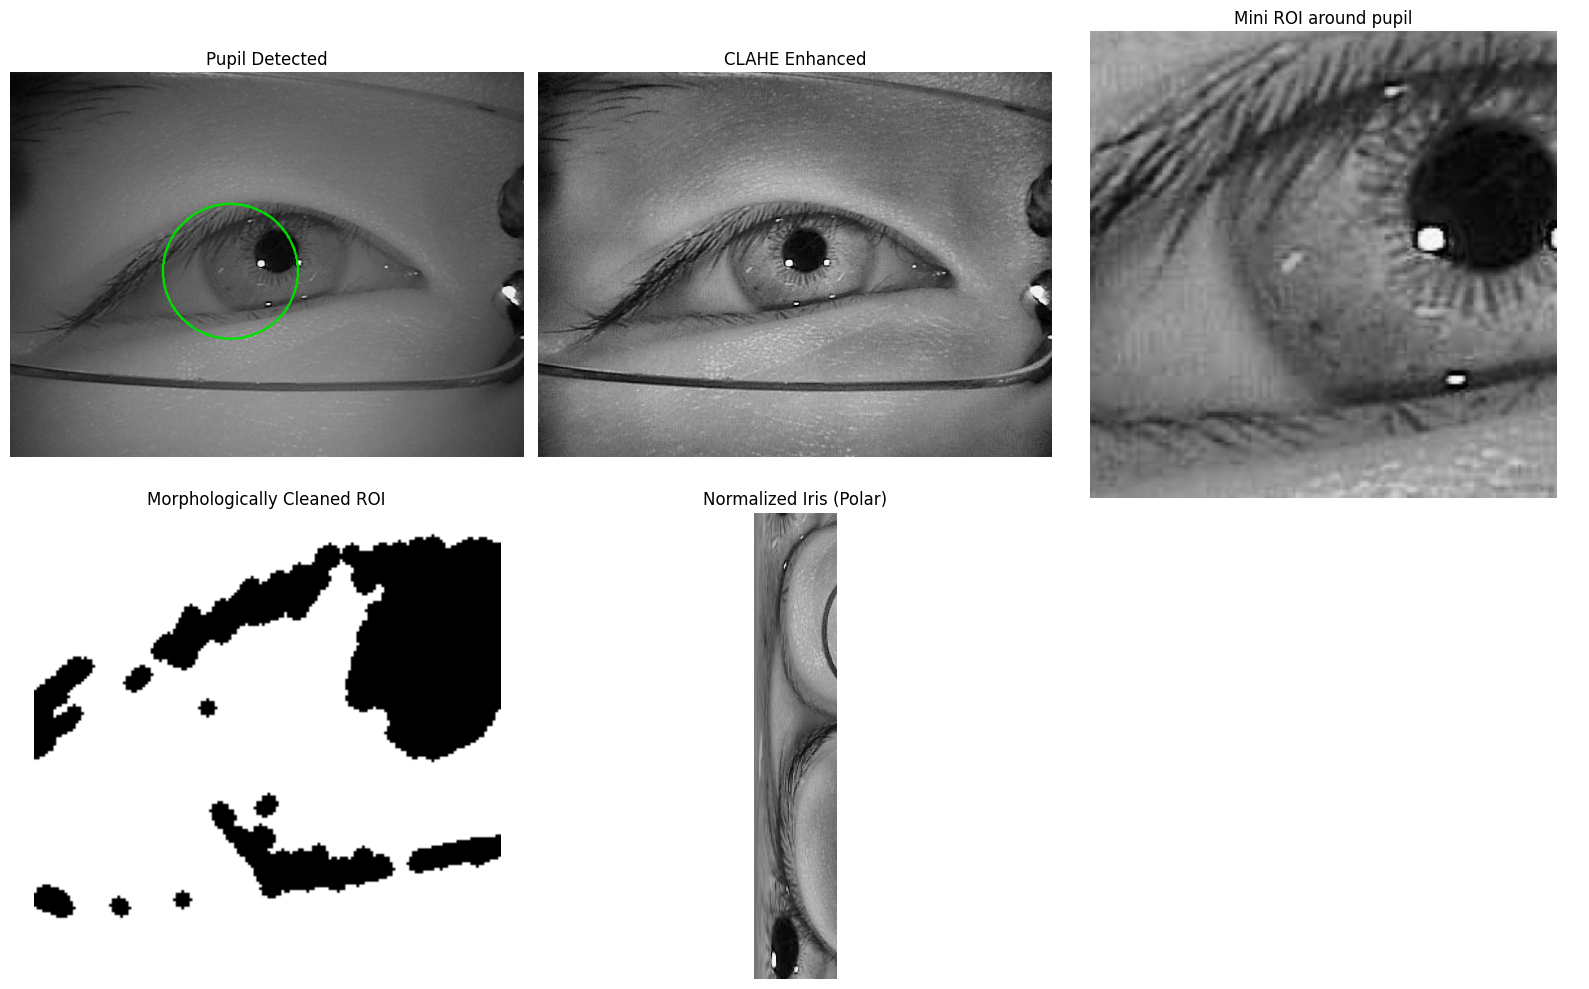

In [ ]:
# Install necessary libraries
!pip install opencv-python-headless scikit-image matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, morphology, filters
from skimage.segmentation import active_contour
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.filters import threshold_otsu
import os

# Load and preprocess image
image_path = "/content/drive/MyDrive/S5487L06.jpg"  # <- update this as needed
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 1. Detect Pupil Center using Hough Circles
def detect_pupil(gray_img):
    circles = cv2.HoughCircles(gray_img, cv2.HOUGH_GRADIENT, dp=1.2, minDist=55,
                                param1=75, param2=55, minRadius=45, maxRadius=85)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        return circles[0][0]  # x, y, r
    else:
        return None

pupil = detect_pupil(gray)
if pupil is None:
    raise Exception("Pupil not detected!")
x, y, r = pupil

# Draw circle on the original image for visualization
image_with_circle = image.copy()
cv2.circle(image_with_circle, (x, y), r, (0, 224, 0), 2)

# 2. Adaptive Histogram Equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_gray = clahe.apply(gray)

# 3. Extract Mini ROI (region around pupil)
roi_size = 2 * r
x1, y1 = max(x - r, 0), max(y - r, 0)
x2, y2 = min(x + r, gray.shape[1]), min(y + r, gray.shape[0])
mini_roi = enhanced_gray[y1:y2, x1:x2]

# 4. Morphological cleanup
thresh = threshold_otsu(mini_roi)
binary = mini_roi > thresh
cleaned = morphology.remove_small_objects(morphology.closing(binary, morphology.disk(3)), min_size=500)

# 5. Active Contour for better iris segmentation
gray_img_float = rgb2gray(image)
s = np.linspace(0, 2*np.pi, 400)
snake_init = np.array([x + r*np.cos(s), y + r*np.sin(s)]).T
snake = active_contour(filters.gaussian(gray_img_float, 3),
                       snake_init, alpha=0.015, beta=10, gamma=0.001)

# 6. Normalize iris using polar transformation (rubber sheet model)
def normalize_iris(image, center, radius, rad_res=64, ang_res=360):
    """ Normalize iris using polar coordinates. """
    theta = np.linspace(0, 2 * np.pi, ang_res)
    r = np.linspace(0, 1, rad_res)

    # Create polar coordinate grid
    r, theta = np.meshgrid(r, theta)
    x = center[0] + r * radius * np.cos(theta)
    y = center[1] + r * radius * np.sin(theta)

    # Clip values to image bounds
    x = np.clip(x, 0, image.shape[1] - 1).astype(np.float32)
    y = np.clip(y, 0, image.shape[0] - 1).astype(np.float32)

    # Sample pixels using interpolation
    polar_iris = cv2.remap(image, x, y, interpolation=cv2.INTER_LINEAR)
    return polar_iris

normalized = normalize_iris(enhanced_gray, (x, y), r*2)  # r*2 to cover full iris

# 7. Display results
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

ax[0, 0].imshow(cv2.cvtColor(image_with_circle, cv2.COLOR_BGR2RGB))
ax[0, 0].set_title("Pupil Detected")

ax[0, 1].imshow(enhanced_gray, cmap='gray')
ax[0, 1].set_title("CLAHE Enhanced")

ax[0, 2].imshow(mini_roi, cmap='gray')
ax[0, 2].set_title("Mini ROI around pupil")

ax[1, 0].imshow(cleaned, cmap='gray')
ax[1, 0].set_title("Morphologically Cleaned ROI")

ax[1, 1].imshow(gray_img_float, cmap='gray')
ax[1, 1].plot(snake[:, 0], snake[:, 1], '-b', lw=2)
ax[1, 1].set_title("Active Contour on Original")

ax[1, 1].imshow(normalized, cmap='gray')
ax[1, ].set_title("Normalized Iris (Polar)")

for a in ax.ravel():
    a.axis('off')
plt.tight_layout()
plt.show()


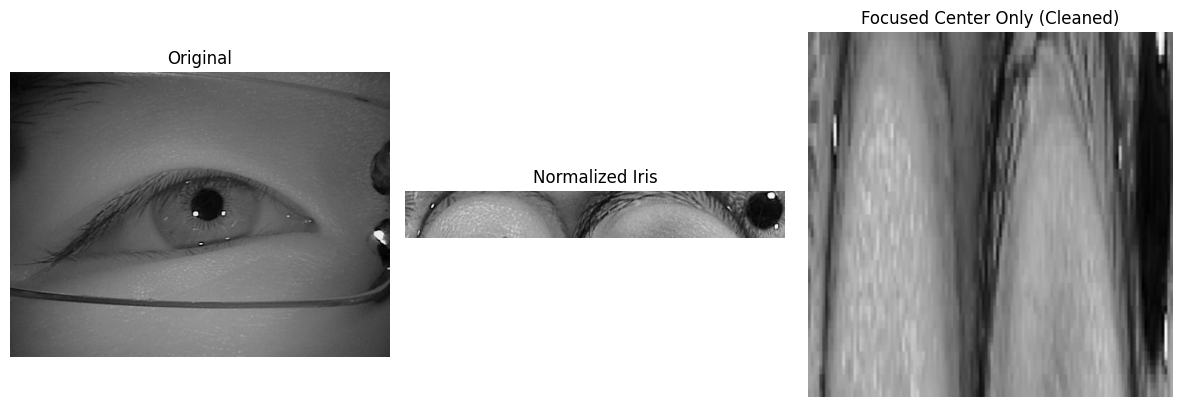

In [ ]:
# Install dependencies
!pip install opencv-python-headless scikit-image matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.color import rgb2gray
from skimage.segmentation import active_contour
from skimage.filters import gaussian
import os

# Load Image
image_path = "/content/drive/MyDrive/S5487L06.jpg"  # Your image here
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect pupil using HoughCircles
def detect_pupil_and_iris(gray_img):
    circles = cv2.HoughCircles(gray_img, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
                                param1=50, param2=30, minRadius=20, maxRadius=60)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        return circles[0][0]  # x, y, r
    return None

pupil = detect_pupil_and_iris(gray)
if pupil is None:
    raise Exception("Pupil not detected.")
x, y, r = pupil

# CLAHE contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Normalize iris using polar unwrap (rubber sheet model)
def unwrap_iris(img, center, r_inner, r_outer, rad_res=64, ang_res=512):
    theta = np.linspace(0, 2 * np.pi, ang_res)
    r = np.linspace(0, 1, rad_res)
    r, theta = np.meshgrid(r, theta)

    # Radius interpolation between pupil and iris
    r_iris = r_inner + r * (r_outer - r_inner)

    # Polar coordinates
    x = center[0] + r_iris * np.cos(theta)
    y = center[1] + r_iris * np.sin(theta)

    # Clip
    x = np.clip(x, 0, img.shape[1] - 1).astype(np.float32)
    y = np.clip(y, 0, img.shape[0] - 1).astype(np.float32)

    # Remap
    polar_iris = cv2.remap(img, x, y, interpolation=cv2.INTER_LINEAR)
    return polar_iris.T  # transpose to keep [radial x angular]

# Iris outer radius slightly larger than pupil
r_inner = r
r_outer = r * 2.2  # adjustable
normalized = unwrap_iris(enhanced, (x, y), r_inner, r_outer)

# Crop central iris zone (ignore eyelids/eyelashes)
focused_central = normalized[8:-8, :]  # remove top/bottom borders

# Resize to model input (e.g., 64x512)
final_crop = cv2.resize(focused_central, (, 128), interpolation=cv2.INTER_AREA)

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(normalized, cmap='gray')
plt.title("Normalized Iris")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_crop, cmap='gray')
plt.title("Focused Center Only (Cleaned)")
plt.axis('off')

plt.tight_layout()
plt.show()


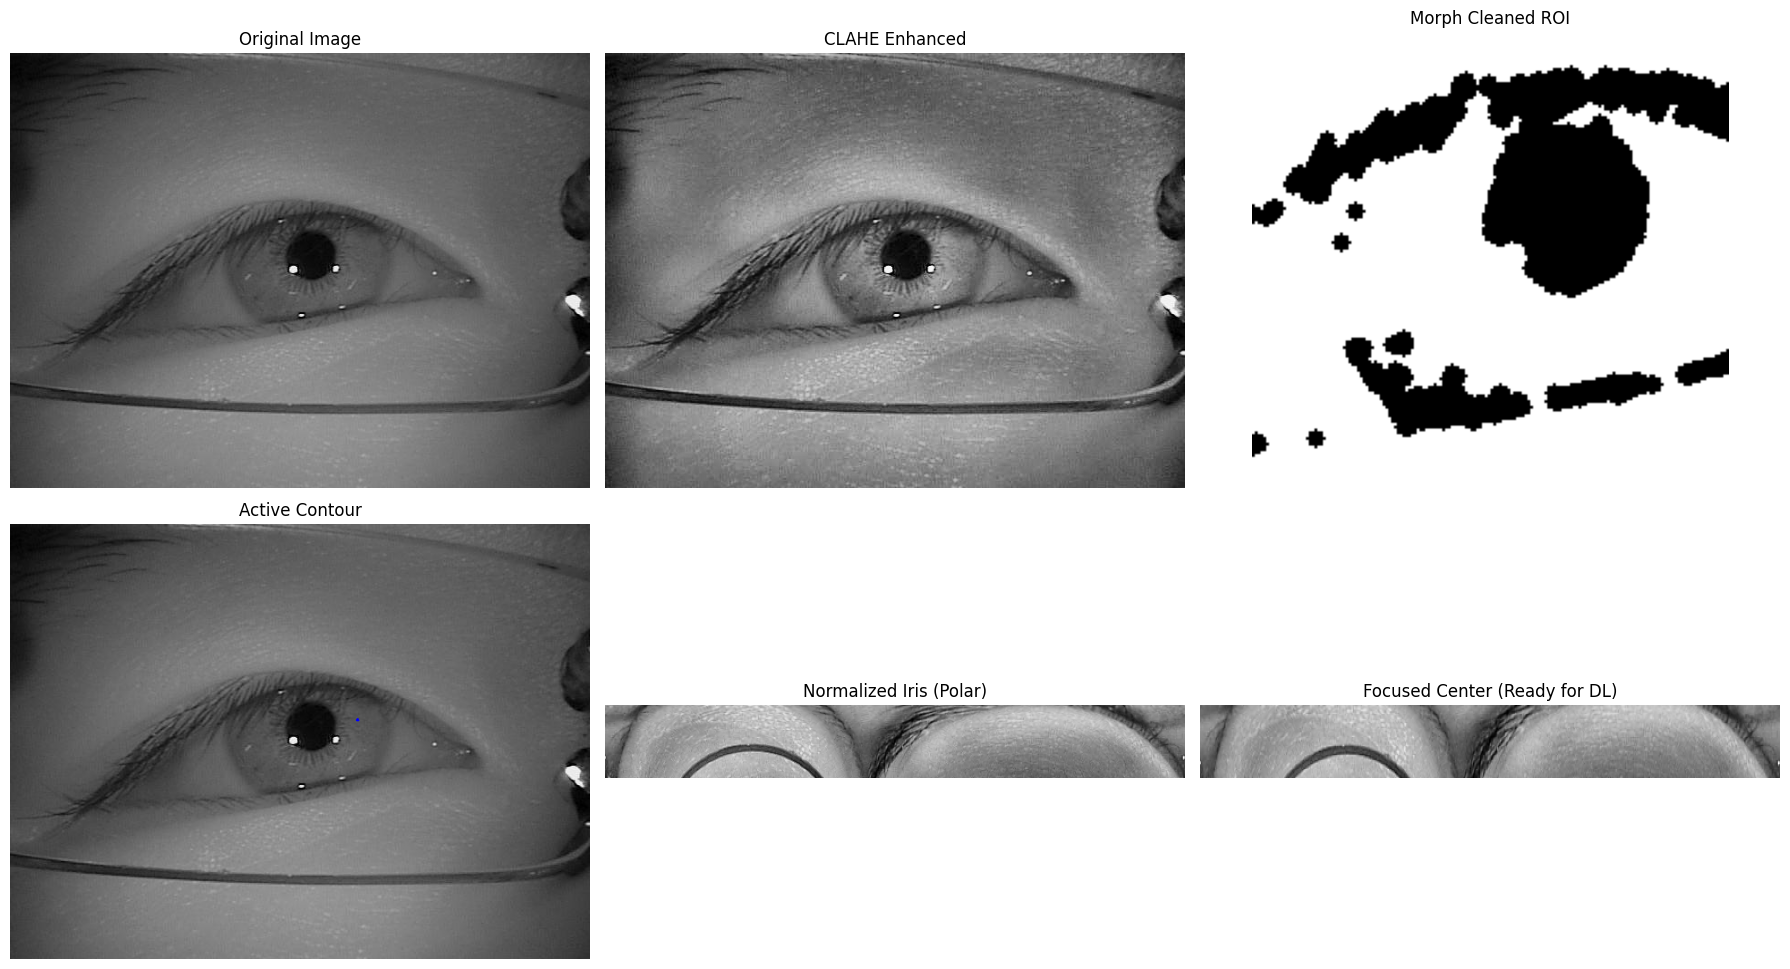

In [ ]:
# Install necessary libraries
!pip install opencv-python-headless scikit-image matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian, threshold_otsu
from skimage.segmentation import active_contour
from skimage.morphology import closing, disk, remove_small_objects

# Load image
image_path = "/content/drive/MyDrive/S5487L06.jpg"  # Change to your image
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Hough Transform: detect pupil circle
def detect_pupil(img):
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp=1.2, minDist=55,
                                param1=75, param2=55, minRadius=45, maxRadius=85)
    if circles is not None:
        return np.uint16(np.around(circles))[0][0]  # (x, y, r)
    return None

pupil = detect_pupil(enhanced)
if pupil is None:
    raise Exception("Pupil not detected.")
x, y, r = pupil

# Morphological preprocessing on localized ROI
roi = enhanced[y - r:y + r, x - r:x + r]
roi_thresh = threshold_otsu(roi)
binary_roi = roi > roi_thresh
cleaned_roi = remove_small_objects(closing(binary_roi, disk(3)), min_size=100)

# Active contour to refine iris boundary
float_img = rgb2gray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
s = np.linspace(0, 2 * np.pi, 400)
init = np.array([x + r * np.cos(s), y + r * np.sin(s)]).T
snake = active_contour(gaussian(float_img, 3), init, alpha=0.015, beta=10, gamma=0.001)

# Rubber Sheet Normalization (polar unwrap)
def normalize_iris(img, center, r_inner, r_outer, rad_res=64, ang_res=512):
    theta = np.linspace(0, 2 * np.pi, ang_res)
    r = np.linspace(0, 1, rad_res)
    r, theta = np.meshgrid(r, theta)

    r_mapped = r_inner + r * (r_outer - r_inner)
    x = center[0] + r_mapped * np.cos(theta)
    y = center[1] + r_mapped * np.sin(theta)

    x = np.clip(x, 0, img.shape[1] - 1).astype(np.float32)
    y = np.clip(y, 0, img.shape[0] - 1).astype(np.float32)

    return cv2.remap(img, x, y, interpolation=cv2.INTER_LINEAR).T

# Define inner (pupil) and outer (iris) radius
r_inner = r
r_outer = int(r * 2.3)  # Adjust outer radius as needed
normalized = normalize_iris(enhanced, (x, y), r_inner, r_outer)

# Focused iris zone extraction (remove eyelid areas)
focused = normalized[8:-8, :]  # top & bottom strip removal

# Resize to model input (e.g. 64x512)
final = cv2.resize(focused, (512, 64), interpolation=cv2.INTER_AREA)

# Display results
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

ax[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0, 0].set_title("Original Image")

ax[0, 1].imshow(enhanced, cmap='gray')
ax[0, 1].set_title("CLAHE Enhanced")

ax[0, 2].imshow(cleaned_roi, cmap='gray')
ax[0, 2].set_title("Morph Cleaned ROI")

ax[1, 0].imshow(float_img, cmap='gray')
ax[1, 0].plot(snake[:, 0], snake[:, 1], '-b', lw=2)
ax[1, 0].set_title("Active Contour")

ax[1, 1].imshow(normalized, cmap='gray')
ax[1, 1].set_title("Normalized Iris (Polar)")

ax[1, 2].imshow(final, cmap='gray')
ax[1, 2].set_title("Focused Center (Ready for DL)")

for a in ax.ravel():
    a.axis('off')
plt.tight_layout()
plt.show()


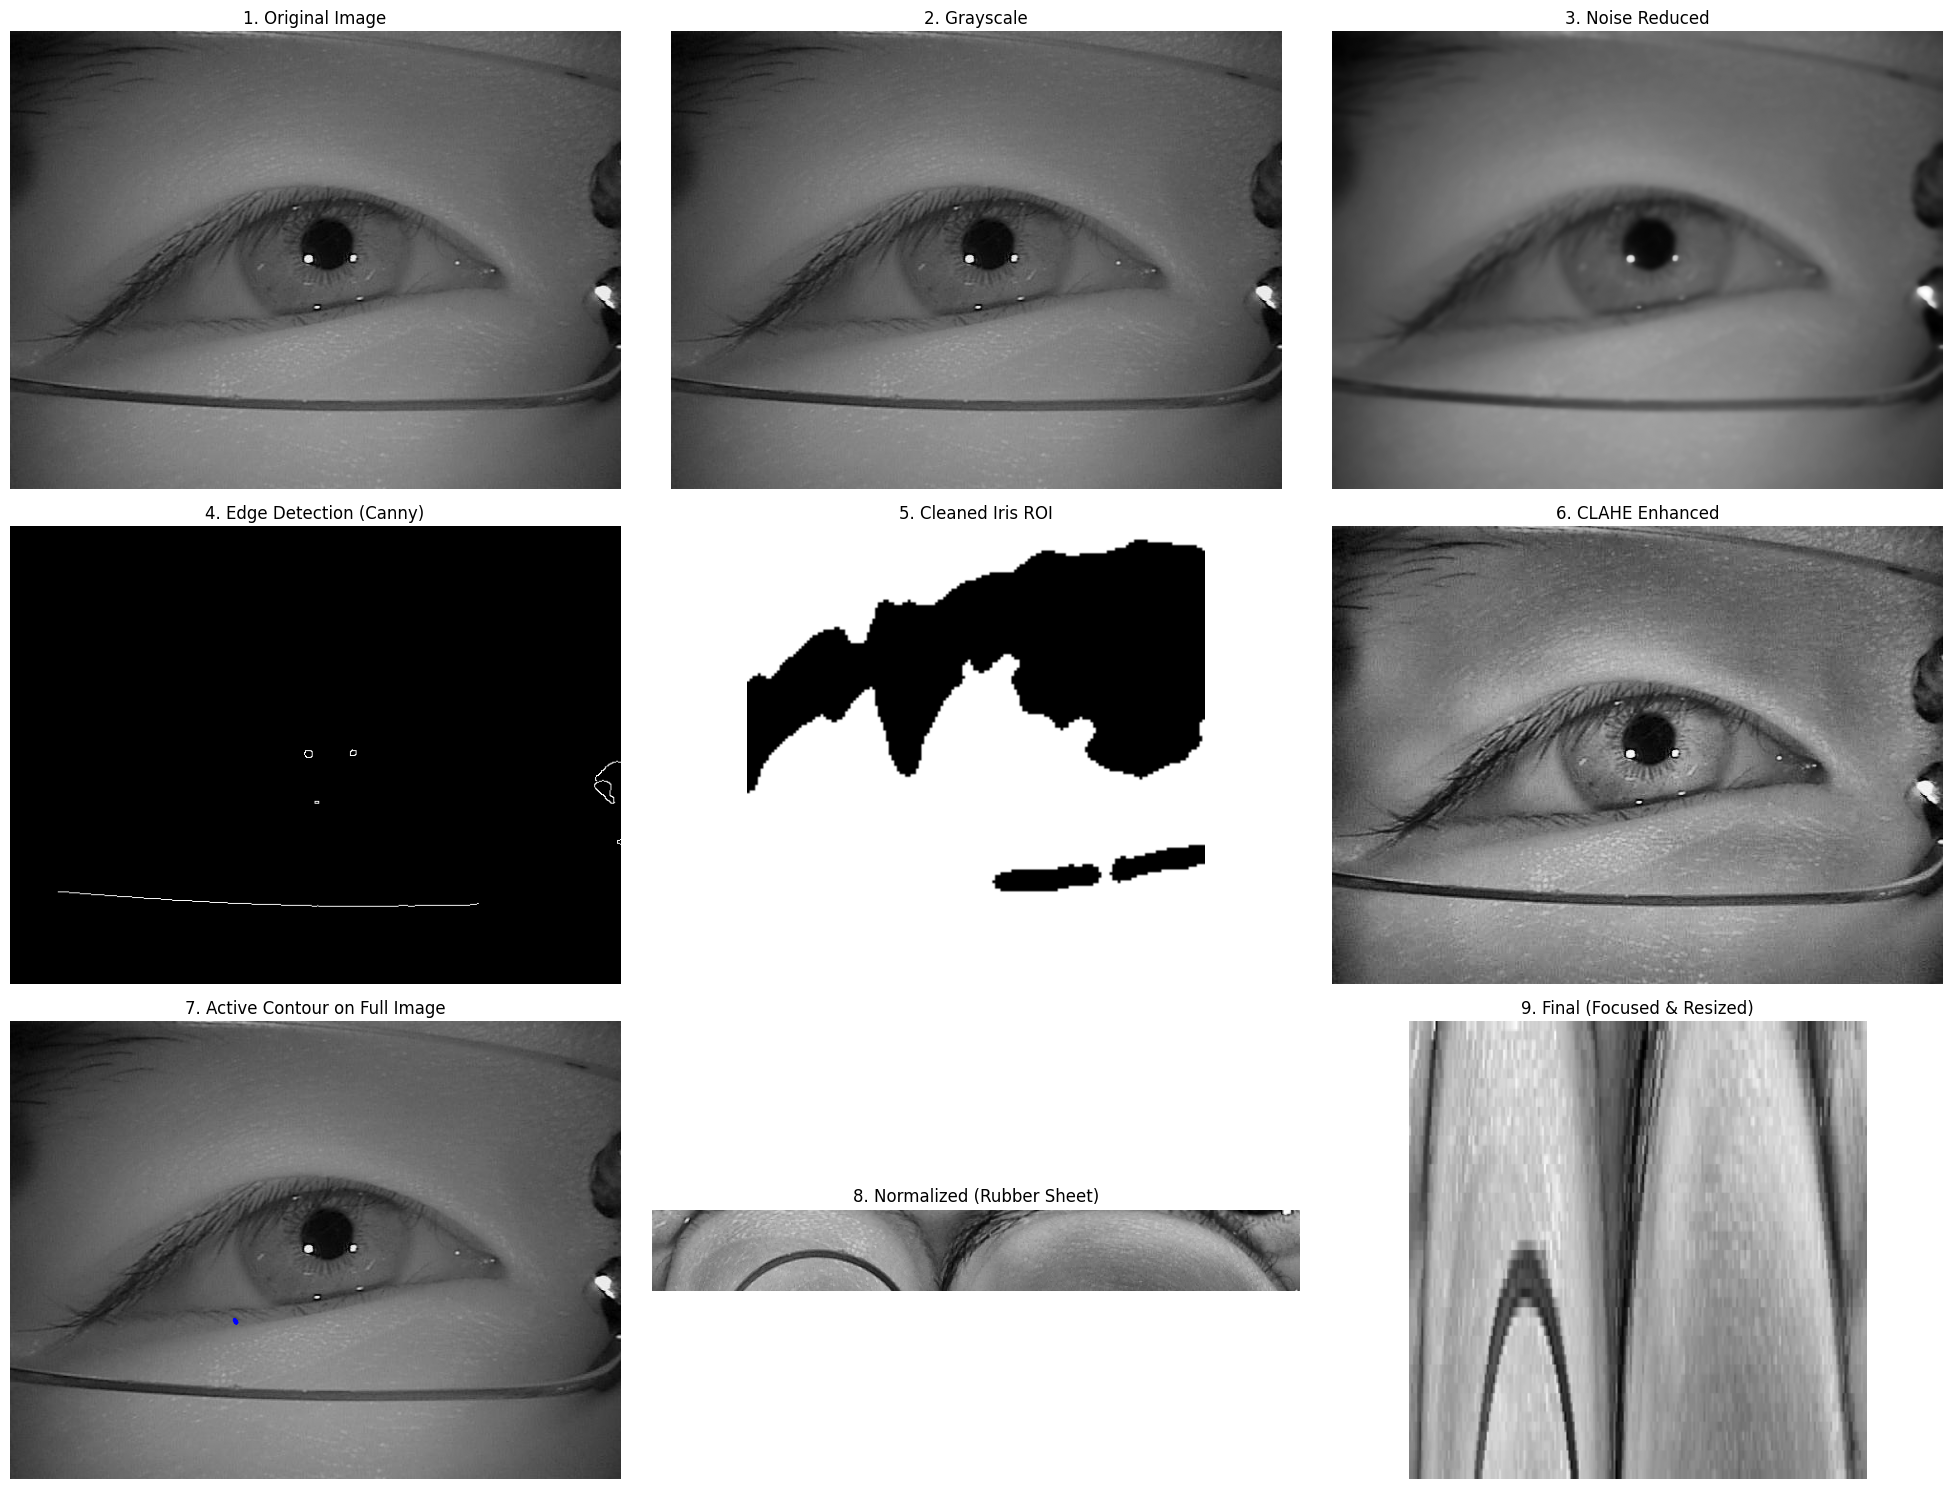

In [ ]:
# Install required packages
!pip install opencv-python-headless scikit-image matplotlib

# Import Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian, threshold_otsu
from skimage.segmentation import active_contour
from skimage.morphology import closing, disk, remove_small_objects

# STEP 1: Load and Convert to Grayscale
image_path = "/content/drive/MyDrive/S5487L06.jpg"  # replace with your image path
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# STEP 2: Noise Reduction (Gaussian + Bilateral)
blurred = cv2.GaussianBlur(gray, (5, 5), 1)
bilateral = cv2.bilateralFilter(blurred, 9, 75, 75)

# STEP 3: Edge Detection (Canny)
edges = cv2.Canny(bilateral, 50, 150)

# STEP 4: Segmentation
# Thresholding (Otsu) for pupil detection
_, thresh = cv2.threshold(bilateral, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Hough Transform to detect pupil circle

def detect_pupil(gray_img):
    circles = cv2.HoughCircles(gray_img, cv2.HOUGH_GRADIENT, dp=1.2, minDist=55,
                                param1=75, param2=55, minRadius=45, maxRadius=85)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        return circles[0][0]  # x, y, r
    else:
        return None

pupil = detect_pupil(gray)
if pupil is None:
    raise Exception("Pupil not detected!")
x, y, r = pupil

# Draw circle on the original image for visualization
image_with_circle = image.copy()
cv2.circle(image_with_circle, (x, y), r, (0, 224, 0), 2)

# Active contour for refining boundary
float_img = rgb2gray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
s = np.linspace(0, 2 * np.pi, 400)
init = np.array([x + r * np.cos(s), y + r * np.sin(s)]).T
snake = active_contour(gaussian(float_img, 3), init, alpha=0.015, beta=10, gamma=0.001)

# STEP 5: Background Removal
roi = bilateral[y - r:y + r, x - r:x + r]
roi_thresh = threshold_otsu(roi)
binary_roi = roi > roi_thresh
morphed = closing(binary_roi, disk(3))
cleaned_roi = remove_small_objects(morphed, min_size=100)

# STEP 6: Contrast Enhancement (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# STEP 7: Normalization (Daugman's Rubber Sheet Model)
def normalize_iris(img, center, r_inner, r_outer, rad_res=64, ang_res=512):
    theta = np.linspace(0, 2 * np.pi, ang_res)
    r = np.linspace(0, 1, rad_res)
    r, theta = np.meshgrid(r, theta)

    r_mapped = r_inner + r * (r_outer - r_inner)
    x = center[0] + r_mapped * np.cos(theta)
    y = center[1] + r_mapped * np.sin(theta)

    x = np.clip(x, 0, img.shape[1] - 1).astype(np.float32)
    y = np.clip(y, 0, img.shape[0] - 1).astype(np.float32)

    return cv2.remap(img, x, y, interpolation=cv2.INTER_LINEAR).T

r_inner = int(r)
r_outer = int(r * 2.3)
normalized = normalize_iris(enhanced, (x, y), r_inner, r_outer)

# STEP 8: Final Preprocessing
focused = normalized[8:-8, :]  # Crop top/bottom eyelids
final = cv2.resize(focused, (224, 224), interpolation=cv2.INTER_AREA)

# ===============================
# Display All Steps for Verification
# ===============================
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

ax[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0, 0].set_title("1. Original Image")

ax[0, 1].imshow(gray, cmap='gray')
ax[0, 1].set_title("2. Grayscale")

ax[0, 2].imshow(bilateral, cmap='gray')
ax[0, 2].set_title("3. Noise Reduced")

ax[1, 0].imshow(edges, cmap='gray')
ax[1, 0].set_title("4. Edge Detection (Canny)")

ax[1, 1].imshow(cleaned_roi, cmap='gray')
ax[1, 1].set_title("5. Cleaned Iris ROI")

ax[1, 2].imshow(enhanced, cmap='gray')
ax[1, 2].set_title("6. CLAHE Enhanced")

ax[2, 0].imshow(float_img, cmap='gray')
ax[2, 0].plot(snake[:, 0], snake[:, 1], '-b', lw=2)
ax[2, 0].set_title("7. Active Contour on Full Image")

ax[2, 1].imshow(normalized, cmap='gray')
ax[2, 1].set_title("8. Normalized (Rubber Sheet)")

ax[2, 2].imshow(final, cmap='gray')
ax[2, 2].set_title("9. Final (Focused & Resized)")

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()
plt.show()


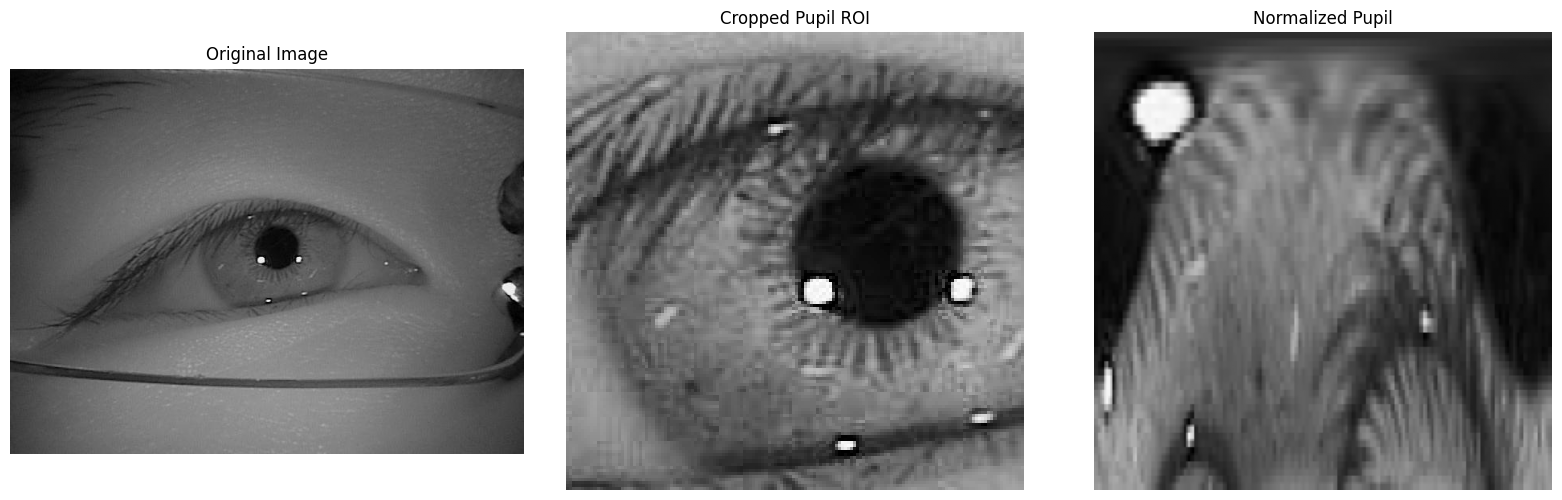

In [ ]:
# Install required packages
!pip install opencv-python-headless scikit-image matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.color import rgb2gray

# Load the image
image_path = "/content/drive/MyDrive/S5487L06.jpg"  # Change to your path
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 1: CLAHE enhancement for better contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Step 2: Detect Pupil (Hough Circle)
def detect_pupil(img):
    blurred = cv2.medianBlur(img, 5)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=45,
                                param1=75, param2=45, minRadius=55, maxRadius=85)
    if circles is not None:
        return np.uint16(np.around(circles))[0][0]  # (x, y, r)
    return None

pupil = detect_pupil(enhanced)
if pupil is None:
    raise Exception("Pupil not detected.")
x, y, r = pupil

# Step 3: Extract circular pupil region as square ROI
margin = 5
roi = enhanced[y - r - margin:y + r + margin, x - r - margin:x + r + margin]

# Step 4: Normalize the circular pupil into a flat rectangular strip
def normalize_circle(img, center, radius, output_size=(64, 128)):
    theta = np.linspace(0, 2 * np.pi, output_size[1])
    r_vals = np.linspace(0, radius, output_size[0])
    r_grid, theta_grid = np.meshgrid(r_vals, theta)

    x_map = center[0] + r_grid * np.cos(theta_grid)
    y_map = center[1] + r_grid * np.sin(theta_grid)

    x_map = np.clip(x_map, 0, img.shape[1] - 1).astype(np.float32)
    y_map = np.clip(y_map, 0, img.shape[0] - 1).astype(np.float32)

    unwrapped = cv2.remap(img, x_map, y_map, interpolation=cv2.INTER_LINEAR)
    return unwrapped.T

normalized = normalize_circle(enhanced, (x, y), r)

# Step 5: Final Resize (optional)
final = cv2.resize(normalized, (224, 224), interpolation=cv2.INTER_AREA)

# Display
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[1].imshow(roi, cmap='gray')
ax[1].set_title("Cropped Pupil ROI")
ax[2].imshow(final, cmap='gray')
ax[2].set_title("Normalized Pupil")
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()


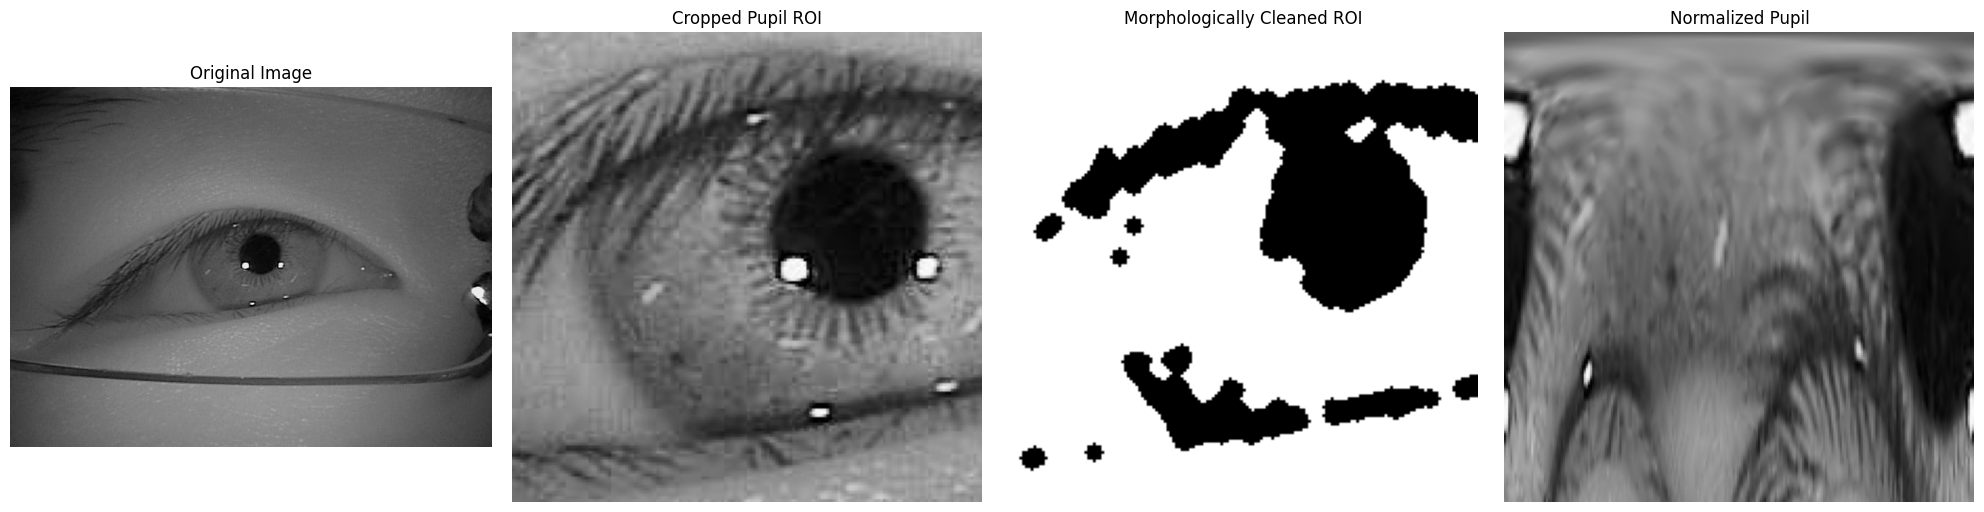

In [ ]:
# Install required packages
!pip install opencv-python-headless scikit-image matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import closing, opening, disk
from skimage.color import rgb2gray

# Load the image
image_path = "/content/drive/MyDrive/S5487L06.jpg"  # Change to your path
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 1: CLAHE enhancement for better contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Step 2: Detect Pupil (Hough Circle)
def detect_pupil(img):
    blurred = cv2.medianBlur(img, 5)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=3, minDist=40,
                                param1=70, param2=40, minRadius=50, maxRadius=80)
    if circles is not None:
        return np.uint16(np.around(circles))[0][0]  # (x, y, r)
    return None

pupil = detect_pupil(enhanced)
if pupil is None:
    raise Exception("Pupil not detected.")
x, y, r = pupil

# Step 3: Extract circular pupil region as square ROI
margin = 5
roi = enhanced[y - r - margin:y + r + margin, x - r - margin:x + r + margin]

# Step 4: Morphological Operations to clean ROI
# Convert to binary using Otsu threshold
otsu_thresh = threshold_otsu(roi)
binary_roi = roi > otsu_thresh

# Apply morphological operations
cleaned_roi = opening(closing(binary_roi, disk(3)), disk(2))

# Step 5: Normalize the pupil to rectangular format
def normalize_circle(img, center, radius, output_size=(224, 224)):
    theta = np.linspace(0, 2 * np.pi, output_size[1])
    r_vals = np.linspace(0, radius, output_size[0])
    r_grid, theta_grid = np.meshgrid(r_vals, theta)

    x_map = center[0] + r_grid * np.cos(theta_grid)
    y_map = center[1] + r_grid * np.sin(theta_grid)

    x_map = np.clip(x_map, 0, img.shape[1] - 1).astype(np.float32)
    y_map = np.clip(y_map, 0, img.shape[0] - 1).astype(np.float32)

    unwrapped = cv2.remap(img, x_map, y_map, interpolation=cv2.INTER_LINEAR)
    return unwrapped.T

normalized = normalize_circle(enhanced, (x, y), r)

# Step 6: Final Resize
final = cv2.resize(normalized, (224, 224), interpolation=cv2.INTER_AREA)

# Display results
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")

ax[1].imshow(roi, cmap='gray')
ax[1].set_title("Cropped Pupil ROI")

ax[2].imshow(cleaned_roi, cmap='gray')
ax[2].set_title("Morphologically Cleaned ROI")

ax[3].imshow(final, cmap='gray')
ax[3].set_title("Normalized Pupil")

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

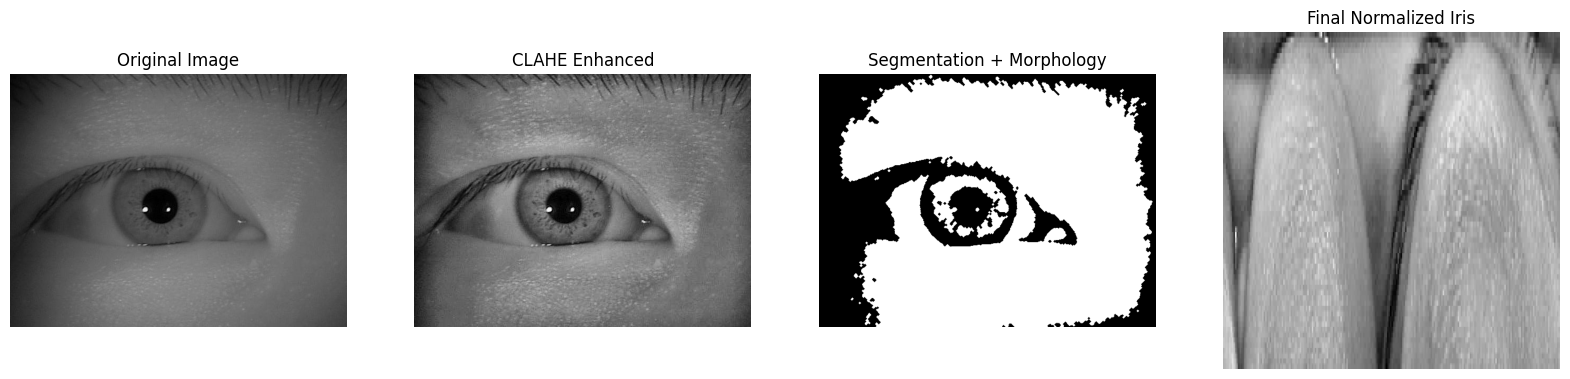

In [ ]:
!pip install opencv-python-headless scikit-image matplotlib segmentation-models-pytorch albumentations

import torch
import numpy as np
import cv2
from skimage.morphology import closing, opening, disk
from skimage.filters import threshold_otsu

def dummy_segmentation_model(gray_img):
    """
    Simulated segmentation: threshold-based mask.
    Replace this with actual model inference later (U-Net, etc.).
    """
    _, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def detect_circle(img, minR=25, maxR=100):
    blurred = cv2.medianBlur(img, 5)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=40,
                                param1=50, param2=30, minRadius=minR, maxRadius=maxR)
    if circles is not None:
        return np.uint16(np.around(circles))[0][0]  # (x, y, r)
    return None

def normalize_iris(img, center, r_inner, r_outer, rad_res=64, ang_res=512):
    theta = np.linspace(0, 2 * np.pi, ang_res)
    r = np.linspace(0, 1, rad_res)
    r, theta = np.meshgrid(r, theta)

    r_mapped = r_inner + r * (r_outer - r_inner)
    x = center[0] + r_mapped * np.cos(theta)
    y = center[1] + r_mapped * np.sin(theta)

    x = np.clip(x, 0, img.shape[1] - 1).astype(np.float32)
    y = np.clip(y, 0, img.shape[0] - 1).astype(np.float32)

    polar = cv2.remap(img, x, y, interpolation=cv2.INTER_LINEAR).T
    return polar

from matplotlib import pyplot as plt

image_path = "/content/drive/MyDrive/Iris Dataset/CASIA-Iris-Thousand/000/L/S5000L01.jpg"  # Update this path


original = cv2.imread(image_path)
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)


enhanced = apply_clahe(gray)


segmentation_mask = dummy_segmentation_model(enhanced)

# 4. Morphological cleanup (removing eyelashes)
cleaned = closing(opening(segmentation_mask, disk(2)), disk(2))

# 5. Circle detection (fallback on CLAHE image)
circle = detect_circle(enhanced)
if circle is None:
    raise Exception("Iris or pupil not detected.")
x, y, r = circle
r_inner = r
r_outer = int(r * 2.5)  # estimate iris outer boundary

# 6. Normalization (Rubber Sheet)
normalized = normalize_iris(enhanced, (x, y), r_inner, r_outer)

# 7. Final Resize + Normalization
final = cv2.resize(normalized, (224, 224), interpolation=cv2.INTER_AREA)

# 8. Visualization
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[1].imshow(enhanced, cmap='gray')
ax[1].set_title("CLAHE Enhanced")
ax[2].imshow(cleaned, cmap='gray')
ax[2].set_title("Segmentation + Morphology")
ax[3].imshow(final, cmap='gray')
ax[3].set_title("Final Normalized Iris")
for a in ax: a.axis('off')
plt.show()
